In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import re

import nltk
from nltk.corpus import stopwords 
from html.parser import HTMLParser

In [2]:
prof = pd.read_csv("../professionals.csv")
answ = pd.read_csv("../answers.csv")
stud = pd.read_csv("../students.csv")
ques = pd.read_csv("../questions.csv")
emai = pd.read_csv("../emails.csv")
matc = pd.read_csv("../matches.csv")
tagq = pd.read_csv("../tag_questions.csv")
taqu = pd.read_csv("../tag_users.csv")

Where professionals and students are from (locations and number). Which locations have both professionals and students. 

In [3]:
print(prof.professionals_location.value_counts().head(10))
print("\n")
print(stud.students_location.value_counts().head(10))

p_loc = np.array(prof['professionals_location'].values.tolist())
s_loc = np.array(stud['students_location'].values.tolist())

i = np.intersect1d(p_loc,s_loc)
print("\nThese are the locations with both professionals and students: {}".format(i))
print("\nIn total, there are {} locations with both professional and students".format(i.size))


New York, New York            1337
California, California         864
Greater New York City Area     745
Boston, Massachusetts          714
Los Angeles, California        617
Atlanta, Georgia               578
Chicago, Illinois              576
Austin, Texas                  574
Houston, Texas                 556
San Francisco Bay Area         513
Name: professionals_location, dtype: int64


New York, New York             1313
Bengaluru, Karnataka, India     890
Los Angeles, California         663
Hyderabad, Telangana, India     597
Boston, Massachusetts           557
San Francisco, California       550
San Jose, California            548
Houston, Texas                  476
Chennai, Tamil Nadu, India      437
Chicago, Illinois               344
Name: students_location, dtype: int64

These are the locations with both professionals and students: ['Abilene, Texas' 'Abu Dhabi, United Arab Emirates' 'Abuja, FCT, Nigeria'
 ... 'York, Pennsylvania' 'Ypsilanti, Michigan' 'nan']

In total, ther

[Text(0, 0, 'New York, New York'),
 Text(0, 0, 'California, California'),
 Text(0, 0, 'Greater New York City Area'),
 Text(0, 0, 'Boston, Massachusetts'),
 Text(0, 0, 'Los Angeles, California'),
 Text(0, 0, 'Atlanta, Georgia'),
 Text(0, 0, 'Chicago, Illinois'),
 Text(0, 0, 'Austin, Texas'),
 Text(0, 0, 'Houston, Texas'),
 Text(0, 0, 'San Francisco Bay Area'),
 Text(0, 0, 'San Francisco, California'),
 Text(0, 0, 'Philadelphia, Pennsylvania'),
 Text(0, 0, 'Bengaluru, Karnataka, India'),
 Text(0, 0, 'Greater Atlanta Area'),
 Text(0, 0, 'Dallas/Fort Worth Area'),
 Text(0, 0, 'Greater Los Angeles Area'),
 Text(0, 0, 'Washington'),
 Text(0, 0, 'Greater Chicago Area'),
 Text(0, 0, 'Houston, Texas Area'),
 Text(0, 0, 'Greater Boston Area')]

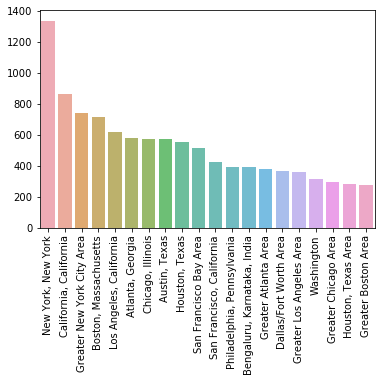

In [4]:
## Let's plot this in bar graph form
location_count = prof['professionals_location'].value_counts()
location_count = location_count[:20,]

g = sns.barplot(location_count.index, location_count.values, alpha=0.8)
g.set_xticklabels(location_count.index, rotation=90)

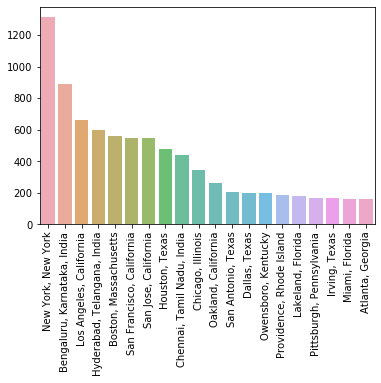

In [5]:
location_count2 = stud['students_location'].value_counts()
location_count2 = location_count2[:20,]
f = sns.barplot(location_count2.index, location_count2.values, alpha=0.8)
f = f.set_xticklabels(location_count2.index, rotation=90)

Which industries are most of these professionals in?

In [6]:
prof.professionals_industry.value_counts().head(10)

Telecommunications                     3166
Information Technology and Services    2109
Computer Software                      1272
Hospital and Health Care                862
Higher Education                        800
Accounting                              781
Financial Services                      639
Education Management                    593
Marketing and Advertising               526
Internet                                427
Name: professionals_industry, dtype: int64

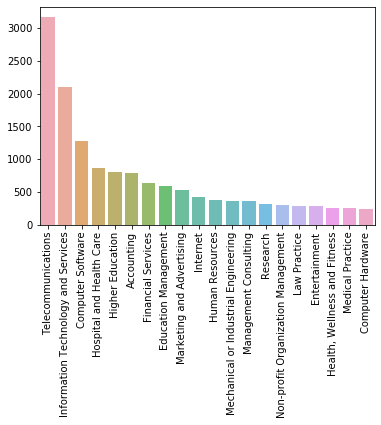

In [7]:
## Let's plot this as a bar graph
industry_count = prof['professionals_industry'].value_counts()
industry_count = industry_count[:20,]
g = sns.barplot(industry_count.index, industry_count.values, alpha=0.8)
g = g.set_xticklabels(industry_count.index, rotation=90)


In [44]:
### Clean headlines 
def clean_names(headline): 
    if type(headline) == str:
        return re.sub(r'at\s.*$', '', headline)
    return headline

# Updated the city columns 
prof.professionals_headline = prof.professionals_headline.apply(clean_names)

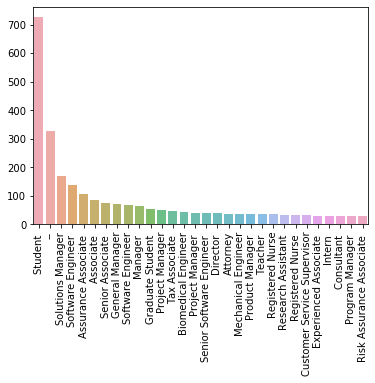

In [45]:
### Let's see what these professionals have as professions
headline_count = prof['professionals_headline'].value_counts()
headline_count = headline_count[:30,]
g = sns.barplot(headline_count.index, headline_count.values, alpha=0.8)
g = g.set_xticklabels(headline_count.index, rotation=90)

I guess a lot of professionals have no profession ;-) 

A lot of people at PwC group. As someone noted, they are partnered with career-village. Eitherway, for optimal results, we will probably need to get rid of "... at Company" words in their headlines using regex.

What are key words (NN) from students' questions? First strip html tags from answers and questions and access the nouns using nltk.tag_pos() and nltk.word_tokenizer()

Here we can then plot all the different NN* to see what words are "big" in students' questions. 

In [9]:
## This class strips all HTML encoding in the responses 
## It takes in a string and returns an HTML-free string
## Usage: strip_tags(df.text_body.iloc[i]) for i in range(0:df.size)

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(str(d))
    def get_data(self):
        return ''.join(self.fed)
    
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [49]:
## method to get all the answer body texts in one string
c = 'questions_body'
def getBodyText(df, col) -> str:
    result = ""
    for index, row in df.iterrows():
        curr = (row[col])
        curr = strip_tags(str(curr))
        result += curr
    return result

a = getBodyText(ques, c)

In [11]:
### tokenize the answers and then classify parts of speech. Keep words that are NN
### Make a dictionary to update the frequency of these individual words across all words. 
# w = word dictionary (pass by reference)
# t = tokenized string

def idNounsFromText(words, t) -> dict:
    t = (nltk.word_tokenize(t))
    print('Finished tokenizing body text')
    
    t = nltk.pos_tag(t)
    print('Finished tagging pos in body text')
    
    for i in t: 
        if (i[1] == "NN" or i[1] == "NNP" or i[1] == "NNS" or i[1] == "NNPS"):
            current = i[0].lower()
            if current in words.keys(): 
                words[current] += 1
            else:
                words[current] = 1
    return words
w = {}
w = idNounsFromText(w, a)

Finished tokenizing body text
Finished tagging pos in body text


In [12]:
#pd.DataFrame(w, index=0).T

l = ["Frequency"]
noun_df = pd.DataFrame.from_records([w], index=l).T

In [13]:
print(noun_df.sort_values(by='Frequency', ascending= False).head(10))

             Frequency
college           9176
school            5891
career            5011
job               3211
engineering       2422
i                 2348
field             2071
business          2027
science           1931
people            1888


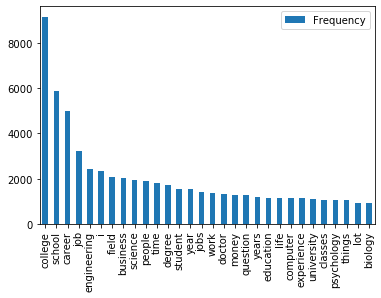

In [14]:
noun_top = (noun_df.sort_values(by='Frequency', ascending= False).head(30))
y = noun_top.plot.bar(y='Frequency')

We can do a similar approach with answers from professionalsCollege, school, jobs, engineering/STEM seem to be big in the students' questions. Some issues here with words that are classified as nouns. 

In [15]:
c = 'answers_body'
temp = answ[:10]
temp.head()
x = getBodyText(answ, 'answers_body')


In [16]:
d = {}
d = idNounsFromText(d, x)

Finished tokenizing body text
Finished tagging pos in body text


In [17]:
answ_df = pd.DataFrame.from_records([d], index=l).T
print(answ_df.sort_values(by='Frequency', ascending= False).head(10))

            Frequency
school          28068
college         24337
time            21407
career          19678
job             18939
people          18586
work            16594
degree          14613
experience      12913
years           11892


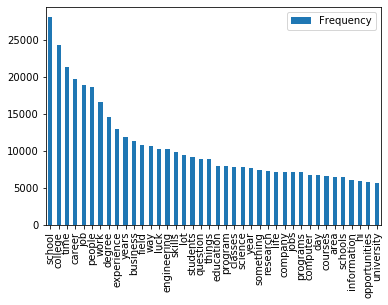

In [18]:
answ_top = (answ_df.sort_values(by='Frequency', ascending= False).head(40))
y = answ_top.plot.bar(y='Frequency')

Eliminate stop words from text and plot the remaining words. Also use lemmatization to consolidate similar words

In [25]:
stop_words = set(stopwords.words("english"))

# filtering them a la datacamp.com :-)
filtered_sent =[]
for w in nltk.word_tokenize(strip_tags(answ.answers_body.iloc[1])):
    if w not in stop_words:
        filtered_sent.append(w)
print(filtered_sent)

['Hi', '.', 'I', 'joined', 'Army', 'I', 'attended', 'college', 'received', 'Bachelor', "'s", 'Degree', 'Criminal', 'Justice', '.', 'Commissioned', 'officers', 'enter', 'Military', 'four', 'year', 'degree', 'receive', 'officer', 'training', 'joining', 'complete', 'tour', '.', 'You', 'prepare', 'taking', 'Reserve', 'Officer', 'Training', 'Corps', '(', 'ROTC', ')', 'high', 'school', 'university', '.', 'You', 'also', 'attend', 'Officer', 'Candidate', 'School', '(', 'OCS', ')', 'graduating', 'college', 'become', 'commissioned', 'earning', 'professional', 'degree', '.', 'If', 'decide', 'earn', 'degree', ',', 'think', 'would', 'like', 'military', '.', 'The', 'experience', 'military', 'rewarding', '.', 'I', 'wish', 'well', 'much', 'success', 'future', '.']


In [55]:

def getNonStopWordsFromText(words, stop_words, t,) -> dict:
    
    t = (nltk.word_tokenize(t))
    print('Finished tokenizing body text')
    
    for i in t:
        if i not in stop_words:
            current = i.lower()
            if current in words.keys():
                words[current] += 1
            else:
                words[current] = 1

    return words

w = {}
w =  getNonStopWordsFromText(w, stop_words, a)

Finished tokenizing body text


In [57]:
#pd.DataFrame(w, index=0).T

l = ["Frequency"]
noStopWords_df = pd.DataFrame.from_records([w], index=l).T
print(noStopWords_df.sort_values(by='Frequency', ascending= False).head(10))
noStopWords_top = (noStopWords_df.sort_values(by='Frequency', ascending= False).head(30))

         Frequency
#            77454
i            44084
.            32235
,            21484
?            11262
college       9176
want          8499
know          6557
would         6293
'm            6077


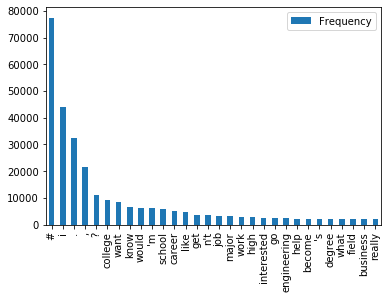

In [58]:
y = noStopWords_top.plot.bar(y='Frequency')
## Don't really care for punctuation/etc. So it looks like a combination of POS and StopWords would help filter out 
## informative features of the text. 